# Reconhecimento de Motivo Harmonicos usando Simple e Plotly
Nessa implementação, utilizamos uma versão modificada do algoritmo SiMPle para criação de uma matriz de similaridade e o cálculo de repetições músicais.

In [8]:
import plotly as py
import plotly.graph_objects as go
import argparse
import click
import itertools
import librosa
import numpy as np
import os
import sys
import time

_EPS = 1e-14

def simpleself(seq, subseq_len):
    
    # prerequisites
    exclusion_zone = int(np.round(subseq_len/2));
    ndim = seq.shape[0]
    seq_len = seq.shape[1]
    matrix_profile_len = seq_len - subseq_len + 1;
    
    # windowed cumulative sum of the sequence
    seq_cum_sum2 = np.insert(np.sum(np.cumsum(np.square(seq),1),0), 0, 0)
    seq_cum_sum2 = seq_cum_sum2[subseq_len:]-seq_cum_sum2[0:seq_len - subseq_len + 1]
    
    # first distance profile
    first_subseq = np.flip(seq[:,0:subseq_len],1)    
    dist_profile = seq_cum_sum2 + seq_cum_sum2[0]
    
    prods = np.full([ndim,seq_len+subseq_len-1], np.inf)
    for i_dim in range(0,ndim):
        prods[i_dim,:] = np.convolve(first_subseq[i_dim,:],seq[i_dim,:])
        dist_profile -= (2 * prods[i_dim,subseq_len-1:seq_len])
    prods = prods[:, subseq_len-1:seq_len] # only the interesting products
    prods_inv = np.copy(prods)
    
    dist_profile[0:exclusion_zone] = np.inf
    
    matrix_profile = np.ndarray((matrix_profile_len,matrix_profile_len))
    matrix_profile[0] = dist_profile[:]

    mp_index = -np.ones((matrix_profile_len), dtype=int)
    mp_index[0] = np.argmin(dist_profile)

    # for all the other values of the profile
    for i_subseq in range(1,matrix_profile_len):
        
        sub_value = seq[:,i_subseq-1, np.newaxis] * seq[:,0:prods.shape[1]-1]
        add_value = seq[:,i_subseq+subseq_len-1, np.newaxis] * seq[:, subseq_len:subseq_len+prods.shape[1]-1]

        prods[:,1:] = prods[:,0:prods.shape[1]-1] - sub_value + add_value
        prods[:,0] = prods_inv[:,i_subseq]
        
        # dist_profile = seq^2 + subseq^2 - 2 * seq.subseq
        subseq_cum_sum2 = seq_cum_sum2[i_subseq]
        dist_profile = seq_cum_sum2 + subseq_cum_sum2 - 2 * np.sum(prods,0)
        
        # excluding trivial matches
        dist_profile[max(0,i_subseq-exclusion_zone+1):min(matrix_profile_len,i_subseq+exclusion_zone)] = np.inf
        
        matrix_profile[i_subseq] = dist_profile[:]
        mp_index[i_subseq] = np.argmin(dist_profile)
        
    return matrix_profile, mp_index


In [9]:
y, sr = librosa.load('../Simple/Mac DeMarco My Old Man (Official Audio).mp3')
chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

sim_matrix, mpindex = simpleself(chroma_cens, 215) # 215 ~ 5sec

/home/martin/.local/lib/python3.8/site-packages/librosa/util/utils.py:1725: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

/home/martin/.local/lib/python3.8/site-packages/librosa/util/utils.py:991: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/martin/.local/lib/python3.8/site-packages/librosa/util/utils.py:1725: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.

/home/martin/.local/lib/python3.8/site-packages/librosa/feature/spectral.py:1096: DeprecationWarning:

`hanning` is depreca

In [53]:
import matplotlib.pyplot as plt

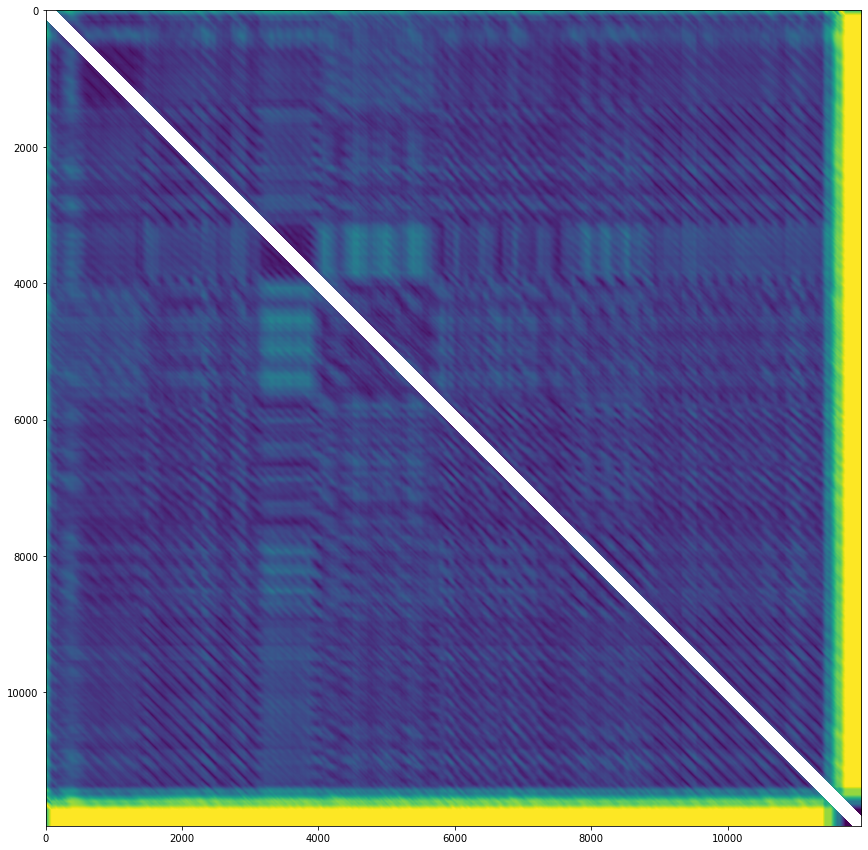

In [4]:
plt.figure(figsize=[15,15])
plt.imshow(sim_matrix)

# Cálculo de Similaridade utilizando diagonais da matriz de similaridade
Percorremos a matriz de similaridade procurando as diagonais de maior tamanho.

In [10]:
def get_diag(sim_matrix, distance_max = 25, exclusion_zone = 25, tam_min = 215):
    diagonal = []
    num_row, num_col = np.shape(sim_matrix)
    for row in range(num_row):
        tam_max=0
        maior_diag = [None]
        for col in range(row,num_col):
            if sim_matrix[row][col]<distance_max: #parametro que define o limitante superior da distancia
                inicio = [row,col]
                tamanho = 0
                while (row+tamanho)<num_row and (col+tamanho)<num_col and sim_matrix[row+tamanho][col+tamanho]<distance_max:
                    tamanho+=1
                if tamanho>tam_max:
                    maior_diag = [inicio,tamanho]
                    tam_max = tamanho
        if(tam_max!=0): #verifica se existe ao menos um ponto 
            linha,coluna = maior_diag[0]
            #atribui infinito a diagonal e seus pontos vizinhos para prevenir valores repetidos ou de baixa informação
            for t in range(tam_max):
                sim_matrix[linha+t][coluna+t-exclusion_zone:coluna+t+exclusion_zone]= np.inf
            if(tam_max > tam_min): #guarda a diagonal somente se ela for de um tamanho satisfatório 
                diagonal.append(maior_diag)
    diagonal.sort(key=lambda x:x[1],reverse=True)#Ordena as diagonais pelo tamanho 
    return diagonal

In [11]:
diagonal = get_diag(sim_matrix)

In [17]:
num_row, num_col = np.shape(sim_matrix)
imagem_diag = np.zeros((num_row,num_col))
for k in range(len(diagonal)):
    x,y = diagonal[k][0]
    for i in range(diagonal[k][1]):
        imagem_diag[x+i][y+i] = np.inf

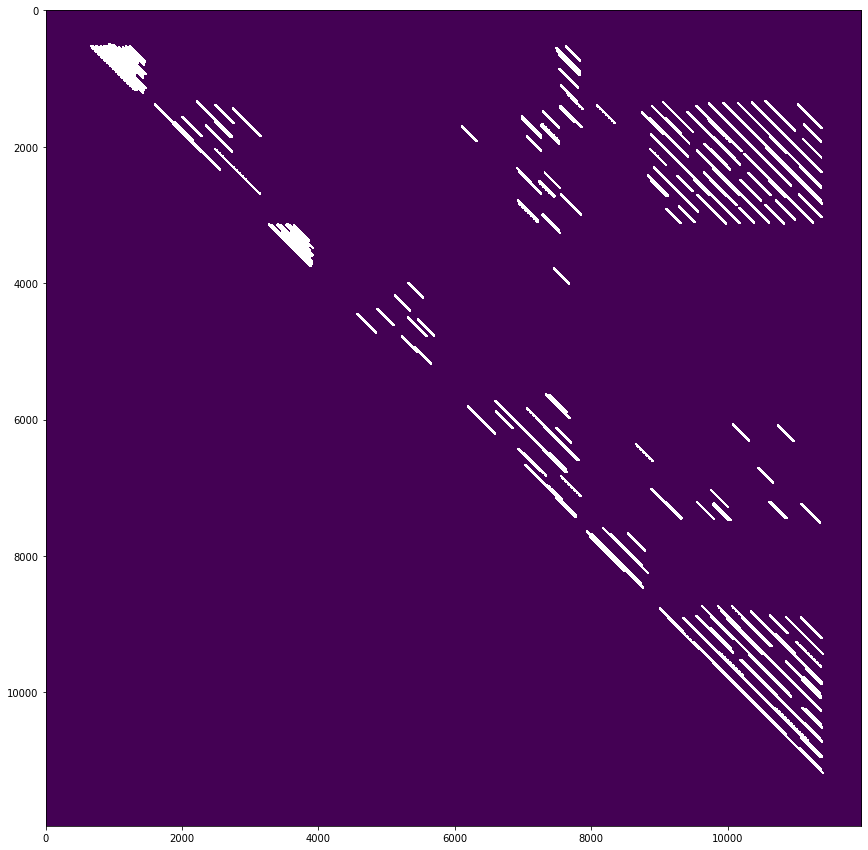

In [8]:
plt.figure(figsize=[15,15])
plt.imshow(imagem_diag)

# Diagram de Arcos das segmentações encontradas
Agradecimentos ao autor da implementação original: https://github.com/empet

In [12]:
def get_b1(b0, b2):
    # b0, b1 list of x, y coordinates
    if len(b0) != len(b2) != 2:
        raise ValueError('b0, b1 must be lists of two elements')
    b1 = 0.5 * (np.asarray(b0)+np.asarray(b2))+\
         0.5 * np.array([0,1.0]) * np.sqrt(3) * np.linalg.norm(np.array(b2)-np.array(b0))
    return b1.tolist() 


def dim_plus_1(b, w):#lift the points b0, b1, b2 to 3D points a0, a1, a2 (see Gallier book)
    #b is a list of 3 lists of 2D points, i.e. a list of three 2-lists 
    #w is a list of numbers (weights) of len equal to the len of b
    if not isinstance(b, list) or  not isinstance(b[0], list):
        raise ValueError('b must be a list of three 2-lists')
    if len(b) != len(w)   != 3:
        raise ValueError('the number of weights must be  equal to the nr of points')
    else:
        a = np.array([point + [w[i]] for (i, point) in enumerate(b)])
        a[1, :2] *= w[1]
        return a
    
def Bezier_curve(bz, nr): #the control point coordinates are passed in a list bz=[bz0, bz1, bz2] 
    # bz is a list of three 2-lists 
    # nr is the number of points to be computed on each arc
    t = np.linspace(0, 1, nr)
    #for each parameter t[i] evaluate a point on the Bezier curve with the de Casteljau algorithm
    N = len(bz) 
    points = [] # the list of points to be computed on the Bezier curve
    for i in range(nr):
        aa = np.copy(bz) 
        for r in range(1, N):
            aa[:N-r,:] = (1-t[i]) * aa[:N-r,:] + t[i] * aa[1:N-r+1,:]  # convex combination of points
        points.append(aa[0,:])                                  
    return np.array(points)

def Rational_Bezier_curve(a, nr):
    discrete_curve = Bezier_curve(a, nr ) 
    return [p[:2]/p[2] for p in discrete_curve]

pl_density = [[0.0, 'rgb(230,240,240)'],
              [0.1, 'rgb(187,220,228)'],
              [0.2, 'rgb(149,197,226)'],
              [0.3, 'rgb(123,173,227)'],
              [0.4, 'rgb(115,144,227)'],
              [0.5, 'rgb(119,113,213)'],
              [0.6, 'rgb(120,84,186)'],
              [0.7, 'rgb(115,57,151)'],
              [0.8, 'rgb(103,35,112)'],
              [0.9, 'rgb(82,20,69)'],
              [1.0, 'rgb(54,14,36)']]

In [13]:
def arc_plot(diagonal, recorte = 43, arc_num = 20):
    data = []
    tooltips = [] #list of strings to be displayed when hovering the mouse over the middle of the circle arcs
    xx = []
    yy = []
    
    diagonal_val = diagonal[:arc_num]
    for i in range(len(diagonal_val)):
        diagonal_val[i][0][0] = diagonal_val[i][0][0]//recorte
        diagonal_val[i][0][1] = diagonal_val[i][0][1]//recorte
        diagonal_val[i][1]  = diagonal_val[i][1]//recorte
    diagonal_val.sort(key= lambda x:x[0][0])
    indices = []
    for i in range(len(diagonal_val)):
        indices.append(diagonal_val[i][0][0])
        indices.append(diagonal_val[i][0][1])
        indices = list(set(indices))
    indices.sort()
    tempo = [f'{indices[k]} segundos' for k in range(len(indices))]
    links = [(diagonal_val[j][0][0], diagonal_val[j][0][1]) for j in range (len(diagonal_val))]
    
    size_diag = [diagonal_val[p][1] for p in range(len(diagonal_val))]
    
    node_trace = dict(type='scatter',
                  x=list(range(len(indices))),
                  y=[0]*len(indices),
                  mode='markers',
                  marker=dict(size=12, 
                              color='rgb(149,197,226)', 
                              colorscale=pl_density,
                              showscale=False,
                              line=dict(color='rgb(50,50,50)', width=0.75)),
                  text=tempo,
                  hoverinfo='text')
    
    X = list(range(len(indices))) # node x-coordinates
    nr = 75 
    for i in range(len(links)):
        tooltips.append(f'tempo de({links[i][0]} até {links[i][1]})={size_diag[i]}')
        j = indices.index(links[i][0])
        k = indices.index(links[i][1])
        b0 = [X[j], 0.0]
        b2 = [X[k], 0.0]
        b1 = get_b1(b0, b2)
        a = dim_plus_1([b0, b1, b2], [1, 0.5, 1])
        pts = Rational_Bezier_curve(a, nr)
        xx.append(pts[nr//2][0]) #abscissa of the middle point on the computed arc
        yy.append(pts[nr//2][1]) #ordinate of the same point
        x,y = zip(*pts)
    
        data.append(dict(type='scatter',
                         x=x, 
                         y=y, 
                         name='',
                         mode='lines', 
                         line=dict(width=size_diag[i]/12, color='#6b8aca', shape='spline'),
                         hoverinfo='none'
                        )
                    )
        
    data.append(dict(type='scatter',
                        x=xx,
                        y=yy,
                        name='',
                        mode='markers',
                        marker=dict(size=0.5, color='#db2e2e'),
                        text=tooltips,
                        hoverinfo='text'))
    data.append(node_trace)
        
    title = " "
        
    layout = dict(
            title=title, 
            font=dict(size=10), 
            width=900,
            height=460,
            showlegend=False,
            xaxis=dict(anchor='y',
                    showline=False,  
                    zeroline=False,
                    showgrid=False,
                    tickvals=list(range(len(indices))), 
                    ticktext=indices,
                    tickangle=50,
                    ),
            yaxis=dict(visible=False), 
            hovermode='closest',
            margin=dict(t=80, b=110, l=10, r=10)    
            )
    fig = go.FigureWidget(data=data, layout=layout)
    fig.show()

In [14]:
arc_plot(diagonal)